In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline,
)
from text3d2video.pipelines.pipeline_utils import load_pipeline

torch.set_grad_enabled(False)

In [2]:
device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingLogic,
)

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr = GenerativeRenderingLogic(
    pipe,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

In [5]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("rumba:latest")
frame_indices = anim.frame_indices(10)
cams, meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()

In [6]:
module_paths = ["layer8", "layer16", "layer32", "layer64"]
screen_resolutions = [8, 16, 32, 64]
uv_resolutions = [screen * 5 for screen in screen_resolutions]

layer_resolution_indices = {
    "layer8": 0,
    "layer16": 1,
    "layer32": 2,
    "layer64": 3,
}

In [7]:
projections, fragments = gr.precompute_rasterization(
    cams, meshes, verts_uvs, faces_uvs, screen_resolutions, uv_resolutions
)

In [8]:
# Mock Extracted post-attn features

from text3d2video.utilities.testing_utils import test_img

frame_indices = [3, 7, 8]

mock_features = {}
for module in module_paths:
    resolution = screen_resolutions[layer_resolution_indices[module]]

    features = [
        test_img(
            txt=f"{i}",
            font_percent=0.8,
            resolution=resolution,
            return_type="pt",
        )
        for i in frame_indices
    ]
    features = torch.stack(features).cuda()
    mock_features[module] = features

: 

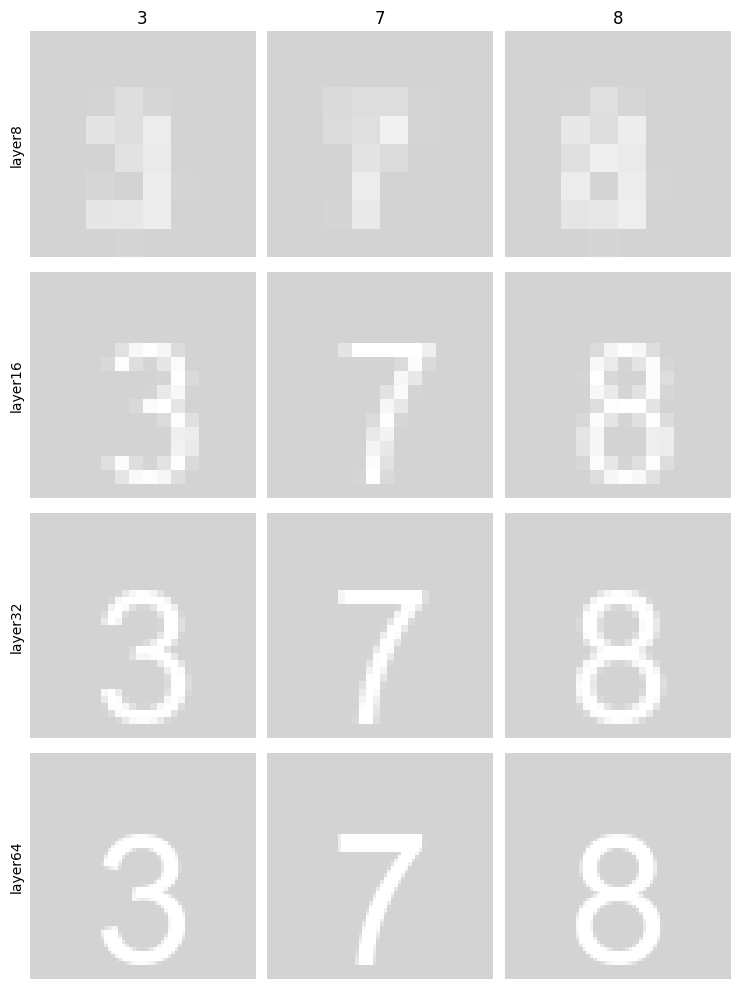

In [13]:
import torchvision.transforms.functional as TF

from text3d2video.utilities.ipython_utils import display_ims_grid

ims = []
for m in module_paths:
    row = []
    for i, _ in enumerate(frame_indices):
        feature = mock_features[m][i].cpu()
        feature = TF.to_pil_image(feature)
        row.append(feature)
    ims.append(row)

display_ims_grid(ims, col_titles=frame_indices, row_titles=module_paths)

In [34]:
feature_textures = gr.aggregate_layer_features(
    mock_features, frame_indices, layer_resolution_indices, uv_resolutions, projections
)

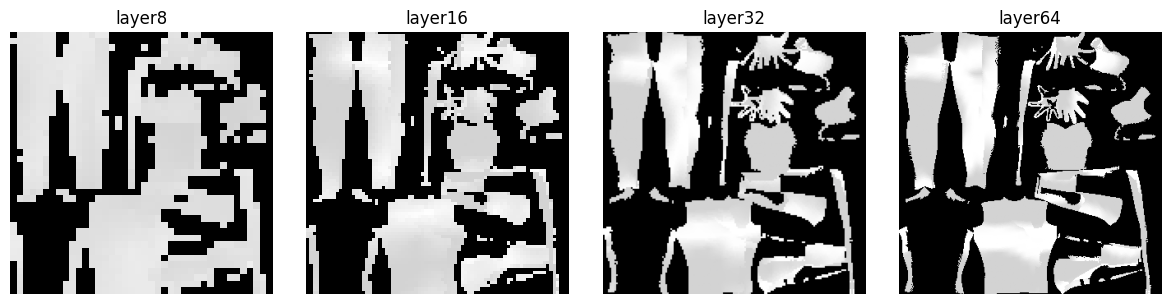

In [33]:
from text3d2video.utilities.ipython_utils import display_ims


texture_labels = list(feature_textures.keys())
textures = [tex.cpu() for tex in feature_textures.values()]

display_ims(textures, titles=texture_labels)

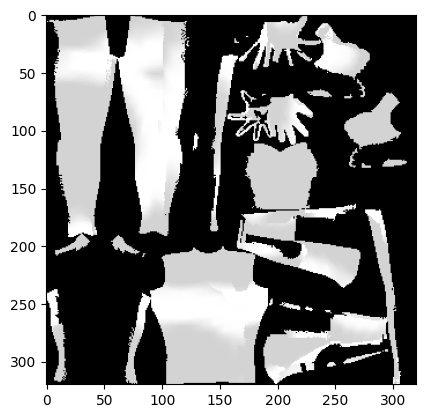

In [16]:
from matplotlib import pyplot as plt

key = module_paths[-1]
texture = feature_textures[key]
plt.imshow(texture.cpu())

# Rendering Feature Textures

In [27]:
from text3d2video.rendering import shade_mesh, shade_meshes


layer = module_paths[-1]
render_indices = [0, 1, 2]


res_idx = layer_resolution_indices[layer]
frags = [fragments[i][res_idx] for i in render_indices]
texture = feature_textures[layer]

render_meshes = meshes[render_indices]

shaded = shade_meshes(render_meshes, frags, texture, verts_uvs, faces_uvs)


torch.Size([3, 3, 64, 64])

In [35]:
from text3d2video.util import dict_map


render_indices = [0, 1, 2]

render_meshes = meshes[render_indices]


def render(layer, texture):
    res_idx = layer_resolution_indices[layer]
    frags = [fragments[i][res_idx] for i in render_indices]
    texture = feature_textures[layer]
    return shade_meshes(render_meshes, frags, texture, verts_uvs, faces_uvs)

rendered = dict_map(feature_textures, render)

: 